In [1]:
import warnings
warnings.filterwarnings('ignore')
# We import all our dependencies.
import numpy as np
import torch
import sys
sys.path.append('../../../')
sys.path.append('/home/sheida.rahnamai/GIT/HDN/')
from models.lvae import LadderVAE
from boilerplate import boilerplate
import lib.utils as utils
import training
from tifffile import imread
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import wandb
import tifffile as tiff
import glob

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [3]:
# path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/contrastive/patches/"
path = "/localscratch/"
patch_size = 64

In [4]:
paths = sorted(glob.glob(path+"training/img/*.tif"))
train_images = tiff.imread(paths)
paths = sorted(glob.glob(path+"training/mask/*.tif"))
train_y = np.array(tiff.imread(paths), dtype=np.int32)
paths = sorted(glob.glob(path+"validation/img/*.tif"))
val_images = tiff.imread(paths)
paths = sorted(glob.glob(path+"validation/mask/*.tif"))
val_y = np.array(tiff.imread(paths), dtype=np.int32)
paths = sorted(glob.glob(path+"testing/img/*.tif"))
test_images = tiff.imread(paths)
paths = sorted(glob.glob(path+"testing/mask/*.tif"))
test_y = np.array(tiff.imread(paths), dtype=np.int32)


In [5]:
model_name = "Contrastive_MAE"
directory_path = "./Contrastive_new_dataloader/" 

In [6]:
# Data-specific
gaussian_noise_std = None
noiseModel = None 
# Training-specific
batch_size=16
virtual_batch = 64
lr=3e-4
max_epochs = 500
steps_per_epoch=1
test_batch_size=100

# Model-specific
num_latents = 3
z_dims = [32]*int(num_latents)
blocks_per_layer = 5
mask_size = 4
batchnorm = True
free_bits = 0.0 # if KLD is less than 1 then the loss won't be calculated
contrastive_learning = True
cl_mode = 'min max'

debug             = False #[True, False]
save_output       = True #[True, False]
use_non_stochastic = False
project           = 'Contrastive_MAE'
img_shape = (64,64)

In [8]:
train_loader, val_loader, data_mean, data_std = boilerplate._make_datamanager(train_images,train_y,val_images,val_y,
                                                                                           test_images,batch_size,
                                                                                           test_batch_size)

model = LadderVAE(z_dims=z_dims,blocks_per_layer=blocks_per_layer,data_mean=data_mean,data_std=data_std,noiseModel=noiseModel,
                  device=device,batchnorm=batchnorm,free_bits=free_bits,img_shape=img_shape,contrastive_learning=contrastive_learning,cl_mode=cl_mode,mask_size=mask_size, use_non_stochastic=use_non_stochastic).cuda()


In [23]:
model

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-1): 2 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

calculate – a public method that orchestrates calculation and printing of output feature map size, jump, receptive image size and the center.

In [17]:
import math;

class ReceptiveFieldCalculator():
    def calculate(self, architecture, input_image_size):
        input_layer = ('input_layer', input_image_size, 1, 1, 0.5)
        self._print_layer_info(input_layer)
        
        for key in architecture:
            current_layer = self._calculate_layer_info(architecture[key], input_layer, key)
            self._print_layer_info(current_layer)
            input_layer = current_layer
            
    def _print_layer_info(self, layer):
        print(f'------')
        print(f'{layer[0]}: n = {layer[1]}; r = {layer[2]}; j = {layer[3]}; start = {layer[4]}')     
        print(f'------')
            
    def _calculate_layer_info(self, current_layer, input_layer, layer_name):
        n_in = input_layer[1]
        j_in = input_layer[2]
        r_in = input_layer[3]
        start_in = input_layer[4]
        
        k = current_layer[0]
        s = current_layer[1]
        p = current_layer[2]

        n_out = math.floor((n_in - k + 2*p)/s) + 1
        padding = (n_out-1)*s - n_in + k 
        p_right = math.ceil(padding/2)
        p_left = math.floor(padding/2)

        j_out = j_in * s
        r_out = r_in + (k - 1)*j_in
        start_out = start_in + ((k-1)/2 - p_left)*j_in
        return layer_name, n_out, j_out, r_out, start_out

Key is the name of the layer and the value is the array consisting of kernel size, stride and padding respectively. This means that layer conv2 has 5×5 kernel, 1×1 striding and 2×2 padding. 

In [25]:
hdn_net = {
    'conv1': [5, 1, 2],
    'pool1': [3, 2, 0],
    'conv2': [5, 1, 2],
    'pool2': [3, 2, 0],
    'conv3': [3, 1, 1],
    'conv4': [3, 1, 1],
    'conv5': [3, 1, 1],
    'pool5': [3, 2, 0],
    'fc6-conv': [6, 1, 0],
    'fc7-conv': [1, 1, 0]
}

In [28]:
calculator = ReceptiveFieldCalculator()
calculator.calculate(hdn_net, 64)

------
input_layer: n = 64; r = 1; j = 1; start = 0.5
------
------
conv1: n = 64; r = 1; j = 5; start = 0.5
------
------
pool1: n = 31; r = 2; j = 7; start = 2.5
------
------
conv2: n = 31; r = 2; j = 15; start = 2.5
------
------
pool2: n = 15; r = 4; j = 19; start = 4.5
------
------
conv3: n = 15; r = 4; j = 27; start = 4.5
------
------
conv4: n = 15; r = 4; j = 35; start = 4.5
------
------
conv5: n = 15; r = 4; j = 43; start = 4.5
------
------
pool5: n = 7; r = 8; j = 51; start = 8.5
------
------
fc6-conv: n = 2; r = 8; j = 91; start = 28.5
------
------
fc7-conv: n = 2; r = 8; j = 91; start = 28.5
------


In [ ]:

model.train() # Model set in training mode
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size, cl_w = 1e-4, kl_w = 1)




In [ ]:
training.train_network(model=model,lr=lr,max_epochs=max_epochs,steps_per_epoch=steps_per_epoch,directory_path=directory_path,
                       train_loader=train_loader,val_loader=val_loader,test_loader=test_loader,
                       virtual_batch=virtual_batch,gaussian_noise_std=gaussian_noise_std,
                       model_name=model_name,val_loss_patience=30, debug=debug, save_output=save_output, project_name=project, batch_size=batch_size, cl_w = 1e-4, kl_w = 1)



In [5]:
import plotly.express as px
import matplotlib.pyplot as plt

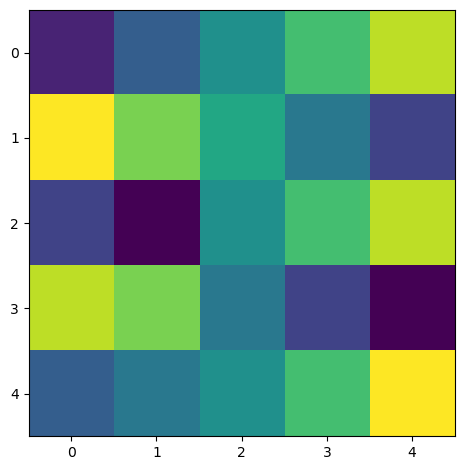

In [7]:
z = [[.1, .3, .5, .7, .9],
     [1, .8, .6, .4, .2],
     [.2, 0, .5, .7, .9],
     [.9, .8, .4, .2, 0],
     [.3, .4, .5, .7, 1]]
fig, ax = plt.subplots()
im = ax.imshow(z)
fig.tight_layout()
plt.show()